# Import libraries

In [1]:
from util import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import trange
import stepic
from PIL import Image, ImageOps

# Mask

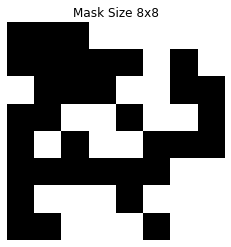

In [2]:
mask_size_w, mask_size_h = 8, 8
mask = np.random.randint(low=0, high=2, size=(mask_size_w, mask_size_h))
# print(mask)

plt.title('Mask Size %dx%d'%mask.shape)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

# Loading images

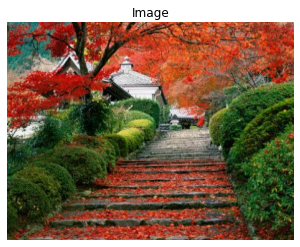

shape (304, 400, 3)


In [3]:
img_path = './img-02.bmp'
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('int16')

img_size_w, img_size_h = img.shape[0], img.shape[1]

img_size_w = img_size_w if img_size_w % mask.shape[0] == 0 else img_size_w + (mask.shape[0] - img_size_w % mask.shape[0])
img_size_h = img_size_h if img_size_h % mask.shape[1] == 0 else img_size_h + (mask.shape[1] - img_size_h % mask.shape[1])

img = cv2.resize(img, (img_size_h, img_size_w), interpolation = cv2.INTER_AREA)

plt.title('Image')
plt.imshow(img)
plt.axis('off')
plt.show()

print('shape', img.shape)

# RS diagram

In [39]:
r_m, s_m, r_neg_m, s_neg_m = [], [], [], []

In [40]:
print('Rm->%f\tSm->%f'%calculate_count_groups(img[:,:,0], mask))
print('R-m->%f\tS-m->%f'%calculate_count_groups(img[:,:,0], -mask))

Rm->0.562632	Sm->0.437368
R-m->0.545263	S-m->0.454737


In [41]:
range_iter =trange(10, leave=True)

channels = [img[:, :, k] for k in range(img.shape[2])]

for i in range_iter:
    temp_rm, temp_sm, temp_r_neg_m, temp_s_neg_m = 0, 0, 0, 0
    for channel in channels:
        img_encoded = scattered_lsb_flipping(channel, 0.1*i)
        
        temp_1, temp_2 = calculate_count_groups(img_encoded, mask)
        temp_rm += temp_1
        temp_sm += temp_2
        
        temp_1, temp_2 = calculate_count_groups(img_encoded, -mask)
        temp_r_neg_m += temp_1
        temp_s_neg_m += temp_2
        
    r_m.append(temp_rm / len(channels)); r_neg_m.append(temp_r_neg_m / len(channels))
    s_m.append(temp_sm / len(channels)); s_neg_m.append(temp_s_neg_m / len(channels))
    
    range_iter.set_postfix_str('Rm->%f, R-m->%f, Sm->%f, S-m->%f'%(r_m[-1], r_neg_m[-1], s_m[-1], s_neg_m[-1]))
    range_iter.refresh()

100%|██████████| 10/10 [00:30<00:00,  3.06s/it, Rm->0.487544, R-m->0.637368, Sm->0.512456, S-m->0.362632]


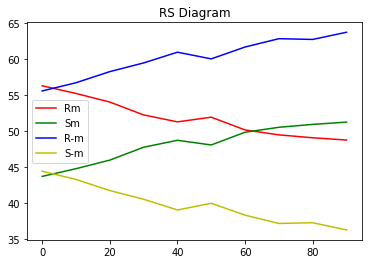

In [42]:
plt.title('RS Diagram')

plt.plot(range(0, 10*len(r_m), 10), 100*np.array(r_m), 'r', label = "Rm")
plt.plot(range(0, 10*len(s_m), 10), 100*np.array(s_m), 'g', label = 'Sm')
plt.plot(range(0, 10*len(r_neg_m), 10), 100*np.array(r_neg_m), 'b', label = 'R-m')
plt.plot(range(0, 10*len(s_neg_m), 10), 100*np.array(s_neg_m), 'y', label = 'S-m')
plt.legend()

plt.savefig('./output-%s.jpg'%img_path.strip().split('/')[-1].split('.bmp')[0].strip(), facecolor='w', edgecolor='none')
plt.show()

# Extrapolation on stego-image

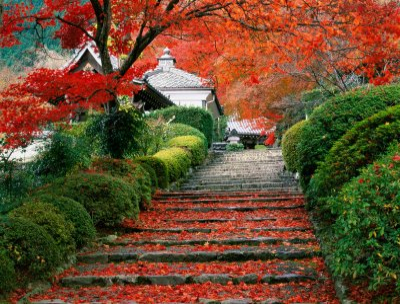

In [4]:
im = Image.fromarray(np.uint8(img))  # Opening using pillow for stepic
im

In [5]:
maximum_message_bytes = img_size_h * img_size_w / 8     # One pixel per bit of a byte of data

# maximum_message_bytes is the maximum number of message bytes that can fit in the image

message_length_percent = 0.4

message_length_bytes = int(message_length_percent * maximum_message_bytes)
message = random_string(message_length_bytes)

In [6]:
stego_image = stepic.encode(im, message.encode('utf-8'))

stego_image = np.array(stego_image).astype('int16').reshape(img.shape)

In [39]:
def RS_quadratic_solver(half_LSBs_flipped, all_LSBs_flipped, p):
    
    RM_p2 = half_LSBs_flipped[0]
    SM_p2 = half_LSBs_flipped[1]
    R_minus_M_p2 = half_LSBs_flipped[2]
    S_minus_M_p2 = half_LSBs_flipped[3]

    RM_1_minus_p2 = all_LSBs_flipped[0]
    SM_1_minus_p2 = all_LSBs_flipped[1]
    R_minus_M_1_minus_p2 = all_LSBs_flipped[2]
    S_minus_M_1_minus_p2 = all_LSBs_flipped[3]

    d0        = RM_p2                -  SM_p2
    d1        = RM_1_minus_p2        -  SM_1_minus_p2
    d_minus_0 = R_minus_M_p2         -  S_minus_M_p2
    d_minus_1 = R_minus_M_1_minus_p2 -  S_minus_M_1_minus_p2

    # a = 2 * (d1 + d0)
    # b = (d_minus_0 - d_minus_1 - d1 - 3*d0)
    # c = (d0 - d_minus_0)

    long_term = (d_minus_0 - d_minus_1 - d1 - 3*d0)

    a = (2 * (d1 + d0))/(1-p)**2
    b = (long_term/(1-p)) - ((2 * (d1 + d0) * p)/(1-p)**2)
    c = (d0 - d_minus_0) + ( ((2 * (d1 + d0) * p**2) / (4*(1-p)**2) ) ) - ( long_term*p / (2*(1-p)) )

    coefficients = [a, b, c]

    return np.roots(coefficients)

### Rm, Sm, R-m, S-m at p/2

In [40]:

channels = [img[:, :, k] for k in range(img.shape[2])]
temp_rm, temp_sm, temp_r_neg_m, temp_s_neg_m = 0, 0, 0, 0

for channel in channels:
    channel = scattered_lsb_flipping(channel, 0.2)      # This is p/2
    temp_1, temp_2 = calculate_count_groups(channel, mask)
    temp_rm += temp_1
    temp_sm += temp_2
    
    temp_1, temp_2 = calculate_count_groups(channel, -mask)
    temp_r_neg_m += temp_1
    temp_s_neg_m += temp_2
    
rm_p_by_2, sm_p_by_2 = temp_rm / len(channels), temp_r_neg_m / len(channels)
r_neg_p_by_2, s_neg_p_by_2 = temp_sm / len(channels), temp_s_neg_m / len(channels)

p_by_2_flipped = [rm_p_by_2, sm_p_by_2, r_neg_p_by_2, s_neg_p_by_2]

In [41]:
new_img  = np.array([channel for channel in channels])
new_img = new_img.reshape(img.shape)
new_img.shape

(304, 400, 3)

### Rm, Sm, R-m, S-m at 1 - p/2

In [42]:
stego_image_all_flipped = np.bitwise_xor(new_img, 1)

channels = [stego_image_all_flipped[:, :, k] for k in range(stego_image_all_flipped.shape[2])]
temp_rm, temp_sm, temp_r_neg_m, temp_s_neg_m = 0, 0, 0, 0
for channel in channels:

    temp_1, temp_2 = calculate_count_groups(channel, mask)
    temp_rm += temp_1
    temp_sm += temp_2
    
    temp_1, temp_2 = calculate_count_groups(channel, -mask)
    temp_r_neg_m += temp_1
    temp_s_neg_m += temp_2
    
rm_1_p_by_2, sm_1_p_by_2 = temp_rm / len(channels), temp_r_neg_m / len(channels)
r_neg_1_p_by_2, s_neg_1_p_by_2 = temp_sm / len(channels), temp_s_neg_m / len(channels)

one_p_by_2_flipped = [rm_1_p_by_2, sm_1_p_by_2, r_neg_1_p_by_2, s_neg_1_p_by_2]

In [48]:
roots = RS_quadratic_solver(np.array(p_by_2_flipped), np.array(one_p_by_2_flipped), message_length_percent)

print(roots)
# roots  = np.real(roots)

[0.34023194+0.25391764j 0.34023194-0.25391764j]


In [49]:
p = abs(roots[0])/(abs(roots[0]) - .5)
p

-5.625791684710421

In [22]:
x =  (1-p)*abs(roots[0]) + p
x

-0.5737384270602479

In [19]:
p = z/(z-.5)
p

0.696505599608606

In [80]:
xCoord = 0.5

# Flipping x% pixels

channels = [img[:, :, k] for k in range(new_img.shape[2])]
temp_rm, temp_sm, temp_r_neg_m, temp_s_neg_m = 0, 0, 0, 0
for channel in channels:

    channel = scattered_lsb_flipping(channel, xCoord)

    temp_1, temp_2 = calculate_count_groups(channel, mask)
    temp_rm += temp_1
    temp_sm += temp_2
    
    temp_1, temp_2 = calculate_count_groups(channel, -mask)
    temp_r_neg_m += temp_1
    temp_s_neg_m += temp_2
    
rm_x, sm_x = temp_rm / len(channels), temp_r_neg_m / len(channels)
r_neg_x, s_neg_x = temp_sm / len(channels), temp_s_neg_m / len(channels)

In [81]:
r_m = [rm_p_by_2, rm_x, rm_1_p_by_2]
s_m = [sm_p_by_2, sm_x, sm_1_p_by_2]
r_neg_m = [r_neg_p_by_2, r_neg_1_p_by_2]
s_neg_m = [s_neg_p_by_2, s_neg_1_p_by_2]

In [82]:
line1 = np.polyfit([0, 1], r_neg_m, 1)
line2 = np.polyfit([0, 1], s_neg_m, 1)

poly1 = np.polyfit([0, min(roots), 1], r_m, 2)
poly2 = np.polyfit([0, min(roots), 1], s_m, 2)

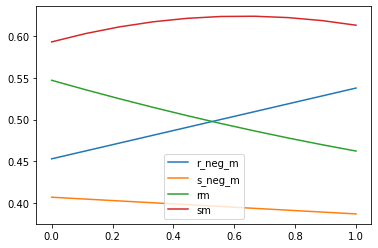

In [83]:
line1_curve = np.poly1d(line1)
x_axis_1 = np.linspace(0, 1, 10)
y_axis_1 = line1_curve(x_axis_1)

line2_curve = np.poly1d(line2)
x_axis_2 = np.linspace(0, 1, 10)
y_axis_2 = line2_curve(x_axis_2)

plt.plot(x_axis_1, y_axis_1, label='r_neg_m')
plt.plot(x_axis_2, y_axis_2, label='s_neg_m')

x_axis_p1 = np.linspace(0, 1, 10)
y_axis_p1 = np.polyval(poly1, x_axis_p1)

x_axis_p2 = np.linspace(0, 1, 10)
y_axis_p2 = np.polyval(poly2, x_axis_p2)

plt.plot(x_axis_p1, y_axis_p1, label = 'rm')
plt.plot(x_axis_p2, y_axis_p2, label = 'sm')

plt.legend()

plt.show()

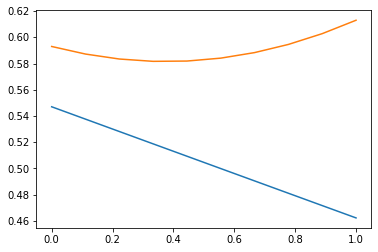

In [54]:
x_axis_p1 = np.linspace(0, 1, 10)
y_axis_p1 = np.polyval(poly1, x_axis_p1)

x_axis_p2 = np.linspace(0, 1, 10)
y_axis_p2 = np.polyval(poly2, x_axis_p2)

plt.plot(x_axis_p1, y_axis_p1)
plt.plot(x_axis_p2, y_axis_p2)
plt.show()